# Keyword recognition with PyTorch

In [140]:
import os
import torch
import torchaudio
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import Dataset, DataLoader

import torchaudio.transforms as T
import torchaudio.functional as F

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

torch.device("cuda" if torch.cuda.is_available() else "cpu")

True
NVIDIA GeForce RTX 3060


device(type='cuda')

Load the Mini Speech dataset

In [141]:
def set_set_to_16000(tensor):
    if tensor.size()[0] < 16000:
        tensor = tensor[:160000, ...]

In [142]:
class MyAudioDataset(Dataset):
    def __init__(self, root_dir, sample_rate=16000, transform=None):
        self.root_dir = root_dir
        self.sample_rate = sample_rate
        self.transform = transform

        # Collect all file paths and labels
        self.file_paths = []
        self.labels = []
        self.label_names = sorted(os.listdir(root_dir))

        for label_idx, label_name in enumerate(self.label_names):
            label_folder = os.path.join(root_dir, label_name)
            for file_name in os.listdir(label_folder):
                if file_name.endswith(".wav"):
                    self.file_paths.append(os.path.join(label_folder, file_name))
                    self.labels.append(label_idx)


    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        waveform, sr = torchaudio.load(file_path)

        # Resample if needed
        if sr != self.sample_rate:
            waveform =  F.resample(
            waveform,
            sr,
            16000,
            lowpass_filter_width=64,
            rolloff=0.9475937167399596,
            resampling_method="sinc_interp_kaiser",
            beta=14.769656459379492,
        )

        # Convert to mono
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # Normalize loudness
        waveform = waveform / torch.max(torch.abs(waveform))

        # Pad shorter clips, trim longer clips
        max_len = self.sample_rate  # 1 second = 16000 samples
        if waveform.shape[1] < max_len:
            waveform = torch.nn.functional.pad(waveform, (0, max_len - waveform.shape[1]))
        else:
            waveform = waveform[:, :max_len]

        # Apply transforms (e.g. MelSpectrogram)
        if self.transform:
            features = self.transform(waveform)
        else:
            features = waveform
            
        return features, label



In [143]:
transform = T.MelSpectrogram(
    sample_rate=16000,
    n_mels=64,
    n_fft=1024,
    hop_length=512
)

from torch.utils.data import DataLoader, random_split
from torch.utils.data import Subset
import random
from collections import defaultdict

# Step 1: Load full dataset
full_dataset = MyAudioDataset("data", sample_rate=16000, transform=transform)

# Step 2: Group indices by class
class_indices = defaultdict(list)
for idx in range(len(full_dataset)):
    _, label = full_dataset[idx]
    class_indices[label].append(idx)

# Step 3: Find minimum class count (so all classes are equal)
min_count = min(len(indices) for indices in class_indices.values())

# Step 4: Randomly sample equal number of items per class
balanced_indices = []
for indices in class_indices.values():
    balanced_indices.extend(random.sample(indices, min_count))

# Step 5: Shuffle all balanced indices
random.shuffle(balanced_indices)

# Step 6: Create a balanced Subset dataset
balanced_dataset = Subset(full_dataset, balanced_indices)

# Step 7: Split train/test from balanced dataset
train_size = int(0.8 * len(balanced_dataset))
test_size = len(balanced_dataset) - train_size

train_dataset, test_dataset = random_split(balanced_dataset, [train_size, test_size])

# Step 8: Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


Inspect one batch

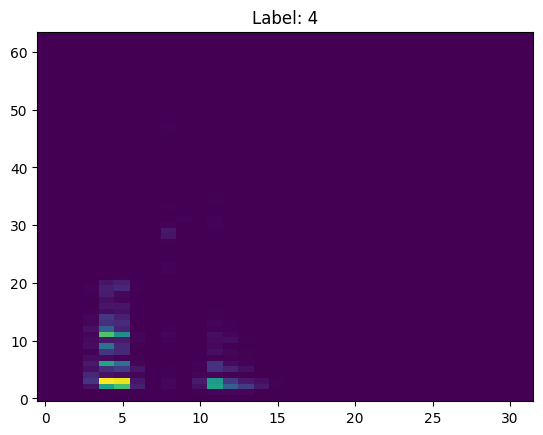

In [144]:
import matplotlib.pyplot as plt
mel, label = next(iter(train_loader))
plt.imshow(mel[0][0].cpu().numpy(), aspect='auto', origin='lower')
plt.title(f"Label: {label[0]}")
plt.show()

## CNN Architecture

In [145]:
import torch.nn as nn
import torch.nn.functional

In [146]:
class KeywordCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        
        # Global average pooling
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        # x: [batch, 1, n_mels, time]
        x = self.pool(torch.nn.functional.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.nn.functional.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.nn.functional.relu(self.bn3(self.conv3(x))))
        
        # Global average pooling
        x = x.mean(dim=[2, 3])  # [batch, channels]
        x = self.dropout(x)
        x = self.fc(x)
        return x

Improved CNN Architecture

In [147]:
class KeywordCNNv2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        def conv_block(in_ch, out_ch, kernel=3, stride=1, pool=True):
            layers = [
                nn.Conv2d(in_ch, out_ch, kernel, stride=stride, padding=kernel//2, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            ]
            if pool:
                layers.append(nn.MaxPool2d(2, 2))
            return nn.Sequential(*layers)

        # Feature extractor
        self.layer1 = conv_block(1, 32)
        self.layer2 = conv_block(32, 64)
        self.layer3 = conv_block(64, 128)
        self.layer4 = conv_block(128, 128, pool=False)

        # Depthwise separable conv (for temporal modeling)
        self.dw_conv = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=(3,1), padding=(1,0), groups=128),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        # Squeeze-and-Excitation (light attention)
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(128, 32, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 128, 1),
            nn.Sigmoid()
        )

        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # Depthwise temporal conv
        x = self.dw_conv(x)

        # Squeeze-and-Excitation
        se = self.se(x)
        x = x * se

        # Global average pooling
        x = x.mean(dim=[2, 3])
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [148]:
model = KeywordCNNv2(num_classes=len(full_dataset.label_names))

Minimal training loop

In [149]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(50):
    model.train()
    running_loss = 0.0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1, Loss: 1.4371
Epoch 2, Loss: 0.9736
Epoch 3, Loss: 0.5467
Epoch 4, Loss: 0.3870
Epoch 5, Loss: 0.2897
Epoch 6, Loss: 0.2233
Epoch 7, Loss: 0.2023
Epoch 8, Loss: 0.1458
Epoch 9, Loss: 0.1270
Epoch 10, Loss: 0.1072
Epoch 11, Loss: 0.0704
Epoch 12, Loss: 0.0689
Epoch 13, Loss: 0.0499
Epoch 14, Loss: 0.0518
Epoch 15, Loss: 0.0419
Epoch 16, Loss: 0.0402
Epoch 17, Loss: 0.0394
Epoch 18, Loss: 0.0211
Epoch 19, Loss: 0.0177
Epoch 20, Loss: 0.0293
Epoch 21, Loss: 0.0275
Epoch 22, Loss: 0.0200
Epoch 23, Loss: 0.0420
Epoch 24, Loss: 0.0194
Epoch 25, Loss: 0.0367
Epoch 26, Loss: 0.0276
Epoch 27, Loss: 0.0087
Epoch 28, Loss: 0.0061
Epoch 29, Loss: 0.0035
Epoch 30, Loss: 0.0033
Epoch 31, Loss: 0.0034
Epoch 32, Loss: 0.0066
Epoch 33, Loss: 0.0414
Epoch 34, Loss: 0.0589
Epoch 35, Loss: 0.0572
Epoch 36, Loss: 0.0409
Epoch 37, Loss: 0.0181
Epoch 38, Loss: 0.0190
Epoch 39, Loss: 0.0121
Epoch 40, Loss: 0.0064
Epoch 41, Loss: 0.0055
Epoch 42, Loss: 0.0088
Epoch 43, Loss: 0.0135
Epoch 44, Loss: 0.03

In [150]:
# Save the entire model to PATH
PATH = 'checkpoints/kws_model.onnx'
torch.save(model.state_dict(), PATH)



Testing on training data

In [151]:
def predict_file(model, filepath, transform, sample_rate, label_names, device):
    # Load audio
    waveform, sr = torchaudio.load(filepath)
    
    # Resample if needed
    if sr != sample_rate:
        waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=sample_rate)(waveform)
    
    # Convert to mono
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    
    # Pad or trim to 1 second (for 16kHz = 16000 samples)
    max_len = sample_rate
    if waveform.shape[1] < max_len:
        waveform = F.pad(waveform, (0, max_len - waveform.shape[1]))
    else:
        waveform = waveform[:, :max_len]

    # Normalize loudness
    waveform = waveform / torch.max(torch.abs(waveform))
    
    # Apply transform (e.g. MelSpectrogram)
    features = transform(waveform).unsqueeze(0).to(device)  # [1, 1, n_mels, time]
    
    # Run model
    model.eval()
    with torch.no_grad():
        outputs = model(features)
        pred_idx = torch.argmax(outputs, dim=1).item()
    
    pred_label = label_names[pred_idx]
    print(f"🎙️ Predicted keyword: {pred_label}")
    return pred_label

In [152]:
# Example configuration
sample_rate = 16000  # or whatever your model was trained on

# Assuming you already defined your transform, e.g.:
# transform = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=64)

# And you have a trained model + label names
file_path = "data/fernando_1.wav"

#predict_file(model, file_path, transform, sample_rate, train_dataset.label_names, device)

Confusion matrix

In [153]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [154]:
cm = confusion_matrix(all_labels, all_preds)
cm

array([[33,  0,  0,  4,  1],
       [ 0, 37,  2,  1,  1],
       [ 0,  1, 34,  1,  3],
       [ 1,  1,  0, 27,  0],
       [ 0,  0,  0,  0, 37]])

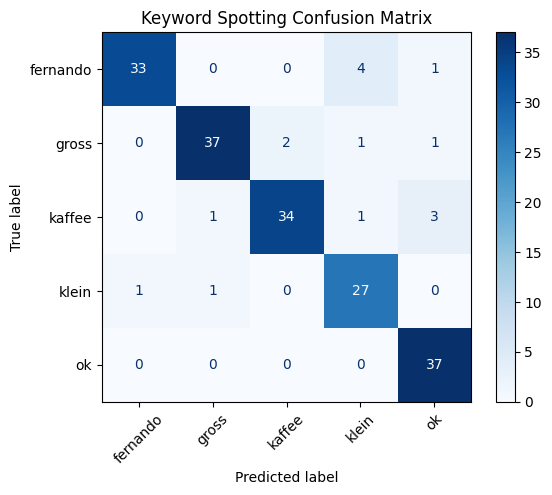

In [155]:
classes = full_dataset.label_names

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Keyword Spotting Confusion Matrix")
plt.show()